In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

In [3]:
import re

import os
import torch
import numpy as np
import pandas as pd
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from src.cbps_torch import CBPS
from pathlib import Path


from src.utils import expand_grid
from src.run_balancing import run_balancing

In [56]:
# Load template to start merging

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Notice template is 1 for land and 0 for water
template_df = (
    template.rename({"x": "lon", "y": "lat"})
    .to_dataframe(name="id_template")
    .reset_index()
    .dropna()
)
template_df["grid_id"] = template_df.index

# Remove the water pixels
template_df = template_df[template_df.id_template == 1]

# Create grid for all years in the sample
template_expanded = expand_grid(
    {"grid_id": template_df.grid_id, "year": np.arange(2000, 2023)}
)

# Add lat and lon to the expanded grid
template_expanded = template_expanded.merge(
    template_df[["grid_id", "lat", "lon"]], on="grid_id"
)

# Load treatments and MTBS data
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather",
).drop(columns=["spatial_ref"])

# Merge with template to clean treatments (they're full of water!)
treatments = template_expanded.merge(treatments, on=["lat", "lon", "year"], how="left")

# Create treatments columns (both wildifre and prescribed are 1!)
treatments = treatments.assign(
    treat=np.select(
        [treatments["Event_ID"] == "nodata", treatments["Event_ID"].isna()],
        [0, 0],
        default=1,
    ),
)

### Merge with output data: intensity and severity with their low types

#### 1. Intensity with the FRP tresholds (Ichoku et al., 2014)


In [59]:
# Merge with FRP data
# Just take wildfires, because we don't have prescribed fire severity data
# We already remove them before, but we are being extra explicit here
treatments = treatments[treatments.Incid_Type != "Prescribed Fire"]

# Load intensity FRP data
frp = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/frp_concat.feather")
frp["year"] = frp.time.dt.year
frp_groupped = frp.groupby(["lat", "lon", "year"], as_index=False).frp.max()

# Find the FRP class from the earliest fire per each grid using the
# FRP threshold values (Ichoku et al. 2014):
conditions = [
    frp_groupped.frp < 100,
    (frp_groupped.frp >= 100) & (frp_groupped.frp < 500),
    (frp_groupped.frp >= 500) & (frp_groupped.frp < 1000),
    (frp_groupped.frp >= 1000) & (frp_groupped.frp < 1500),
    frp_groupped.frp >= 1500,
]
choices = [1, 2, 3, 4, 5]

# Asigning FRP class to each fire
frp_groupped["class_frp"] = np.select(conditions, choices, default=np.nan)

# Merge with wildfires data
treatments = treatments.merge(frp_groupped, on=["lat", "lon", "year"], how="left")
treatments["class_frp"] = treatments["class_frp"].fillna(0)

In [60]:
treatments

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat,frp,class_frp
0,941,2000,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0
1,941,2001,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0
2,941,2002,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0
3,941,2003,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0
4,941,2004,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9420380,966116,2018,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0
9420381,966116,2019,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0
9420382,966116,2020,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0
9420383,966116,2021,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0


#### 2. Severity from Landsat and scaling from -1 to 1

In [61]:
# Load intensity FRP data
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_alt.feather"
).drop(columns=["band"])

# Scale DNBR values
dnbr_scaled = MinMaxScaler(feature_range=(-1, 1)).fit_transform(
    dnbr.dnbr.values.reshape(-1, 1)
)
dnbr["dnbr_scaled"] = dnbr_scaled

# Find the DNBR class from the earliest fire per each grid using the
# DNBR threshold values:
conditions = [
    (dnbr.dnbr >= 0) & (dnbr.dnbr < 0.1),
    (dnbr.dnbr >= 0.1) & (dnbr.dnbr < 0.270),
    (dnbr.dnbr >= 0.270) & (dnbr.dnbr < 0.440),
    (dnbr.dnbr >= 0.440) & (dnbr.dnbr < 0.660),
    dnbr.dnbr >= 0.660,
]
choices = [1, 2, 3, 4, 5]

# Asigning FRP class to each fire
dnbr["class_dnbr"] = np.select(conditions, choices, default=np.nan)

# Merge with wildfires data
treatments = treatments.merge(dnbr, on=["lat", "lon", "Event_ID"], how="left")
treatments["class_dnbr"].fillna(0, inplace=True)

In [62]:
treatments

,grid_id,year,lat,lon,Event_ID,Ig_Date,Incid_Name,Incid_Type,treat,frp,class_frp,dnbr,dnbr_scaled,class_dnbr
0,941,2000,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
1,941,2001,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
2,941,2002,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
3,941,2003,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
4,941,2004,449152.596997,-348913.82085,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9420380,966116,2018,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
9420381,966116,2019,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
9420382,966116,2020,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0
9420383,966116,2021,-603847.403003,278086.17915,nodata,NaT,None,None,0,<NA>,0.0,NaN,NaN,0.0


### Load covariates

In [63]:
treats_wide = pd.pivot(
    treatments,
    index="grid_id",
    columns="year",
    values=["treat", "class_dnbr", "class_frp"],
)
treats_wide.columns = [f"{col}_{year}" for col, year in treats_wide.columns]
treas_wide = treats_wide.reset_index()
treats_wide

,treat_2000,treat_2001,treat_2002,treat_2003,treat_2004,treat_2005,treat_2006,treat_2007,treat_2008,treat_2009,...,class_frp_2013,class_frp_2014,class_frp_2015,class_frp_2016,class_frp_2017,class_frp_2018,class_frp_2019,class_frp_2020,class_frp_2021,class_frp_2022
grid_id,,,,,,,,,,,,,,,,,,,,,
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
966113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
966114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
dict_paths = {
    "prism": "/mnt/sherlock/oak/prescribed_data/processed/prism.feather",
    "disturbances": "/mnt/sherlock/oak/prescribed_data/processed/disturbances.feather",
    "dem": "/mnt/sherlock/oak/prescribed_data/processed/dem.feather",
    "frp": "/mnt/sherlock/oak/prescribed_data/processed/frp_wide.feather",
    "land_type": "/mnt/sherlock/oak/prescribed_data/processed/land_type.feather",
}

# Load datasets and merge with template
data = []
for key, path in dict_paths.items():
    print(key)
    df = pd.read_feather(path)

    # Remove columns if present
    if "lat" in df.columns:
        df = df.drop(columns=["lat", "lon"])
    data.append(df)

# Merge all datasets
df = reduce(lambda x, y: x.merge(y, on="grid_id", how="left"), data)
df = df.merge(treats_wide, on="grid_id")

# Save some memory
del data

prism
disturbances
dem
frp
land_type


In [102]:
def run_balancing(
    df,
    focal_year,
    treat_col,
    class_col,
    row_id,
    reg_list,
    lr_list,
    metrics,
    save_path,
    intensity_class=1,
    **kwargs,
):
    """Run balancing for a given focal year using CBPS.

    This function run the CBPS balancing algorithm for a given focal year and
    saves the weights for analysis. The function does rely on a wide dataframe
    with all columns correctly labeled as "{var}_{year}". If more than one number
    is in the column name, the function will select the first and use this to
    filter the dataframe columns.

    We want to do balancing after a focal year for a given treatment year. To do
    this we will keep all columns that exist before the focal year up to the treatment
    year. This will allow us to balance the data for the treatment year using the
    data available before the treatment year.

    Other arguments can be passed to the CBPS function using the kwargs argument.

    Args:
        df (pd.DataFrame): A wide dataframe with all columns correctly labeled
        focal_year (int): The year to be used as the f  ocal year
        treat_col (str): The name of the treatment column
        row_id (str): The name of the column to be used as row id
        reg_list (list): A list with the regularization parameters to be used
        lr_list (list): A list with the learning rate parameters to be used
        metrics (str ot list): The method to be used for assess balace in standarized differences
        save_path (str): If True, the function will save the results to a file
        intesnity_class (int): The intensity/severity class to use to define control
        **kwargs: Other arguments to be passed to the CBPS function

    Returns:
        None
    """

    # Define treatment with treatment column and class column
    treat_class = (df[treat_col] * df[class_col]).values
    w = np.where(treat_class >= intensity_class, 1, 0)
    
    # Row id using grid_id
    id_col = df[row_id].values
    id_col = id_col[w == 0]

    # Drop grid_id and treatment
    df = df.drop(columns=[row_id, treat_col])

    # Select columns to drop for balancing (all before the focal year)
    cols_keep = [
        col
        for col in df.columns.tolist()
        if re.search(r"\d+", col)
        and 2000 < int(re.findall(r"\d+", col)[0]) < focal_year
    ]

    # Add columns without digists, these are the covariates that are stable in time
    cols_keep += [col for col in df.columns if not re.search(r"\d+", col)]

    # Keep columns before focal year
    df = df[cols_keep]

    # Drop some columns that we don't need!
    df = df.drop(columns=[col for col in df.columns if "treat" in col])

    # Scale data
    X = MinMaxScaler().fit_transform(df.values)

    # Run CBPS for all combinations of regularization and learning rate
    for reg, lr in product(reg_list, lr_list):
        cbps = CBPS(X=X, W=w, estimand="ATT", reg=reg, lr=lr, **kwargs)
        weights = cbps.weights(numpy=True)

        # Save results as a dataframe
        df_results = pd.DataFrame(weights)
        df_results.columns = [f"weights_{cbps.reg}_{cbps.lr}"]

        # Add row id
        df_results[row_id] = id_col

        # Save standarized differences for all metrics
        list_metrics = []
        for metric in metrics:
            std_diffs = cbps._covariate_differences(metric=metric, device="cpu")
            std_diffs_df = pd.concat(std_diffs, axis=1)
            std_diffs_df.columns = [
                f"std_unweighted_{metric}",
                f"std_weighted_{metric}",
            ]
            list_metrics.append(std_diffs_df)

        # Merge all metrics and add covariate name
        std_diffs_df = pd.concat(list_metrics, axis=1)

        # If cbps has an intercept, at it to the column name
        if cbps.intercept:
            cols = ["Intercept"] + df.columns.tolist()
        else:
            cols = df.columns.tolist()
        std_diffs_df["covar"] = cols

        # Save loss to a dataframe
        df_loss = pd.DataFrame(
            {"loss": cbps.loss, "lr": np.array(cbps.lr_decay), "iter": cbps.niter}
        )

        if save_path:
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            df_results.to_feather(
                f"{save_path}/weights_{focal_year}_{lr}_{reg}.feather"
            )
            std_diffs_df.to_feather(
                f"{save_path}/std_diffs_{focal_year}_{lr}_{reg}.feather"
            )
            df_loss.to_feather(f"{save_path}/loss_{focal_year}_{lr}_{reg}.feather")

        # Clean memory
        del cbps, weights, df_results, std_diffs_df
        torch.cuda.empty_cache()

    return None

In [103]:
run_balancing(
    df=df[df.land_type.isin([2])].dropna(),
    focal_year=2019,
    treat_col="treat_2019",
    class_col="class_frp_2019",
    row_id="grid_id",
    reg_list=[0, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1],
    lr_list=[1, 5e-2, 5e-3, 5e-4, 5e-5],
    intercept=True,
    niter=10_000,
    metrics=["smd", "asmd"],
    save_path="./results",
)

Optimizing CBPS...:  76%|███████▌  | 7557/10000 [01:15<00:24, 100.12it/s]

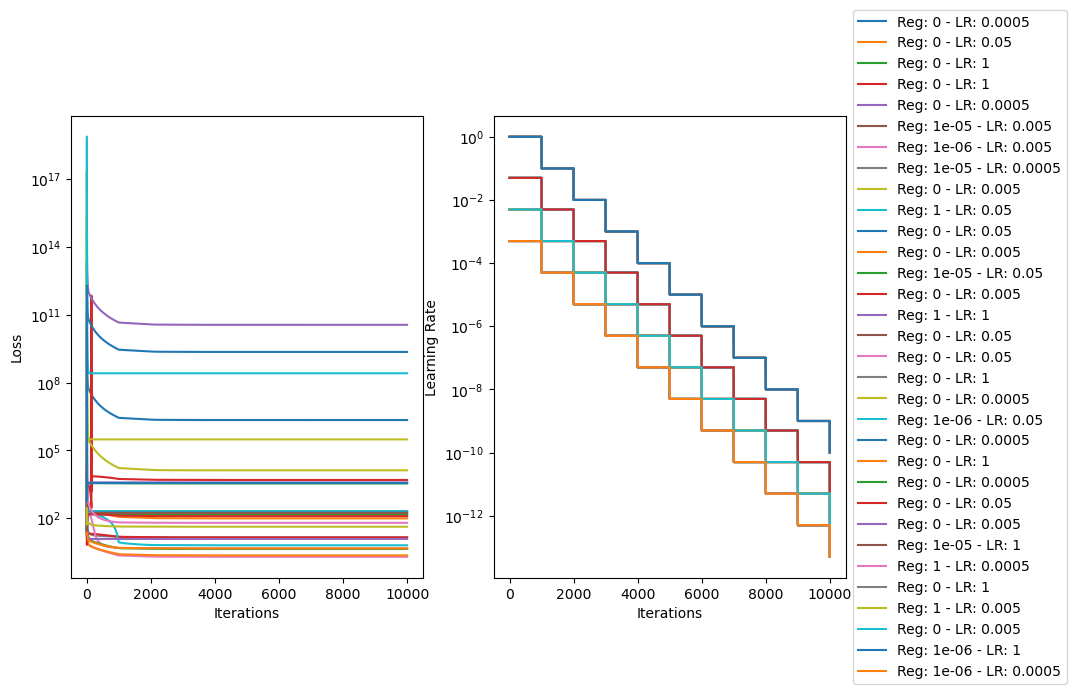

In [6]:
paths = list(Path("./results/").rglob("loss_*"))

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

for path in paths:
    reg = "_".join(path.name.split("_")[1:3])

    # Split regularization from learning rate
    lr = reg.split("_")[0]
    reg = reg.split("_")[1]
    reg = reg.split(".")[0]

    loss = pd.read_feather(path)

    # Plot loss
    ax[0].plot(loss.loss, label=f"Reg: {reg} - LR: {lr}")
    ax[1].plot(loss.lr, label=f"Reg: {reg} - LR: {lr}")

    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Iterations")
    ax[0].set_yscale("log")

    ax[1].set_ylabel("Learning Rate")
    ax[1].set_xlabel("Iterations")
    ax[1].set_yscale("log")

    # Move the legend outside the plot
    ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

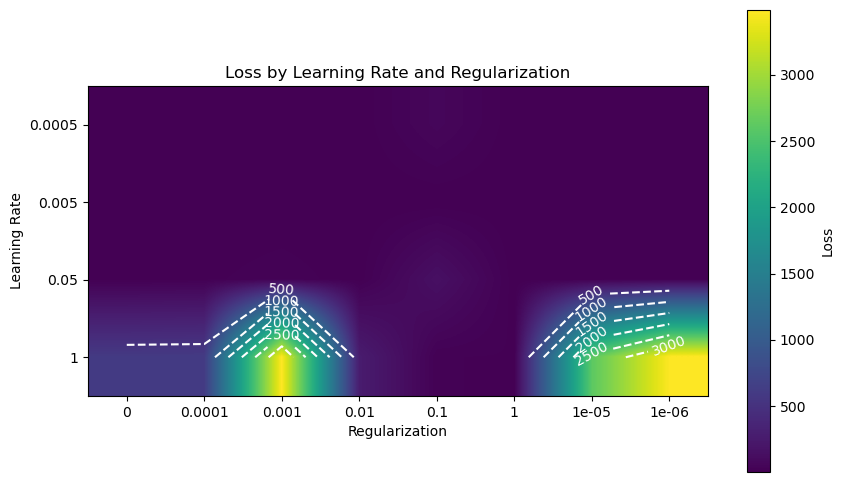

In [7]:
# Read in all the loss data to plot it nicely!
loss_cv = []
for path in paths:
    reg = "_".join(path.name.split("_")[1:3])
    loss = pd.read_feather(path)
    loss["cv_type"] = reg
    loss_cv.append(loss)
loss_cv = pd.concat(loss_cv)

# Split cv_type column into reg and lr columns and remove the ".feather" part
loss_cv["lr"] = loss_cv.cv_type.str.split("_").str[0]
loss_cv["reg"] = [
    ".".join([a for a in f if "feather" != a])
    for f in loss_cv.sort_values("loss")
    .cv_type.str.split("_")
    .str[1]
    .str.split(".")
    .tolist()
]

# Create a mesharray to plot the loss and the contours
cv = loss_cv.groupby(["lr", "reg"], as_index=False).loss.min()

reg = cv.reg.unique()
lr = cv.lr.unique()
loss = cv.loss.values.reshape(len(lr), len(reg))

# Plot loss array as a heatmap with smoothing adding reg and lr values as axis labels
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(loss, cmap="viridis", interpolation="bilinear")

# Add colorbar with the loss values
cbar = fig.colorbar(cax)
cbar.set_label("Loss")

# Add contour lines to the plot
CS = ax.contour(loss, colors="white", linestyles="--")
ax.clabel(CS, inline=1, fontsize=10)

ax.set_xticks(np.arange(len(reg)))
ax.set_yticks(np.arange(len(lr)))

ax.set_xticklabels(reg)
ax.set_yticklabels(lr)

plt.ylabel("Learning Rate")
plt.xlabel("Regularization")
plt.title("Loss by Learning Rate and Regularization")
plt.show()

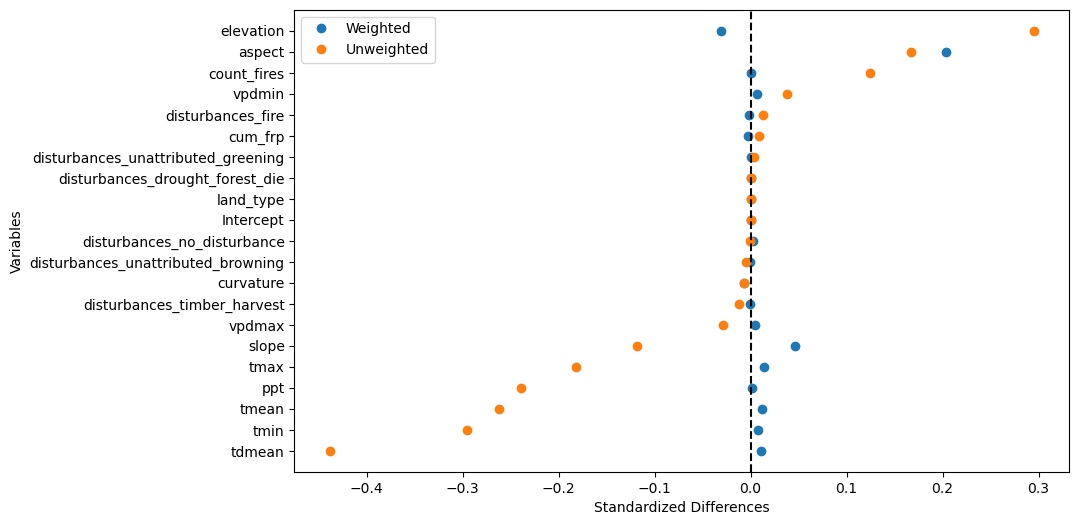

In [8]:
# Load the std_diffs with the lowest loss
best_model = cv.sort_values("loss").iloc[1]
path_to_best_model = (
    f"./results/std_diffs_{best_model['lr']}_{best_model['reg']}.feather"
)
std_diffs = pd.read_feather(path_to_best_model)
std_diffs

# Add family_covar column to the dataframe to aggregate covariates
std_diffs["family_covar"] = [
    "_".join([i for i in c.split("_") if not i.isdigit()])
    for c in std_diffs.covar.tolist()
]

std_diffs.drop(columns="covar", inplace=True)

# Group by family_covar and calculate the mean of the standarized differences
std_diffs_grouped = (
    std_diffs.groupby("family_covar", as_index=False)
    .mean()
    .sort_values("std_unweighted_smd")
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    std_diffs_grouped.std_weighted_smd,
    std_diffs_grouped.family_covar,
    "o",
    label="Weighted",
)
ax.plot(
    std_diffs_grouped.std_unweighted_smd,
    std_diffs_grouped.family_covar,
    "o",
    label="Unweighted",
)
ax.axvline(0, color="black", linestyle="--")

# Add labels to axis
ax.set_ylabel("Variables")
ax.set_xlabel("Standardized Differences")
# Add legend to the plot
ax.legend()

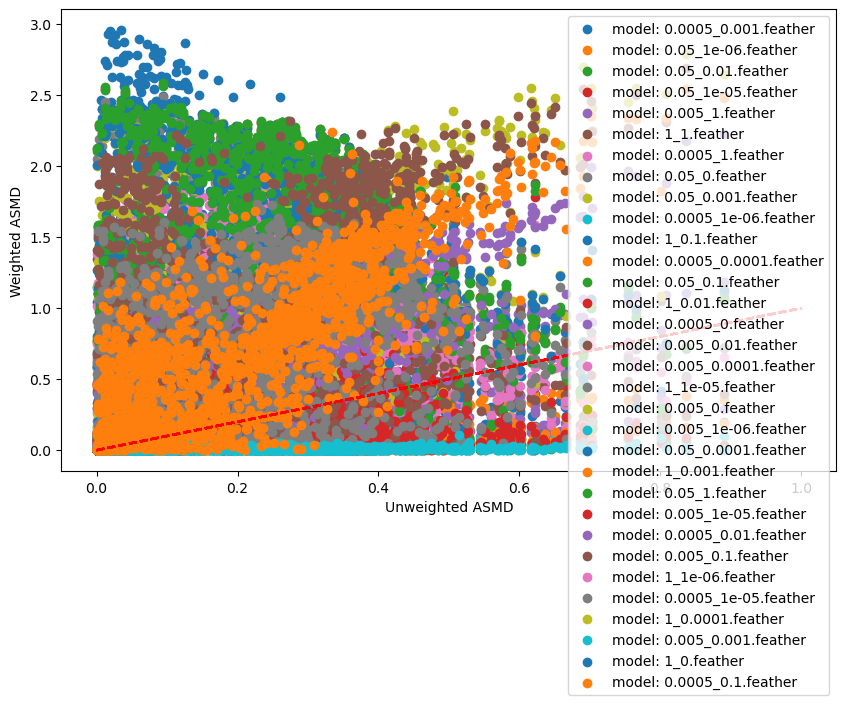

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over all the std_diff paths and plot the results
for path in list(Path("./results/").rglob("std_diffs_*")):
    reg = "_".join(path.name.split("_")[2:4])
    std_diffs = pd.read_feather(path)

    # Plot std_diffs
    ax.scatter(
        std_diffs.std_unweighted_asmd,
        std_diffs.std_weighted_asmd,
        label=f"model: {reg}",
    )

    # Add a 45 degree line
    x = np.linspace(0, 1, 100)
    ax.plot(x, x, "r--")

    # Add label to axis
    ax.set_xlabel("Unweighted ASMD")
    ax.set_ylabel("Weighted ASMD")

    # Add the legend
    plt.legend()

In [11]:
# Plot weights in a map
path_to_best_model = f"./results/weights_{best_model['lr']}_{best_model['reg']}.feather"
weights = pd.read_feather(path_to_best_model)
weights = template_df.merge(weights, on="grid_id")

gdf = gpd.GeoDataFrame(
    weights, geometry=gpd.points_from_xy(weights.lon, weights.lat), crs="EPSG:3310"
)

<Axes: >

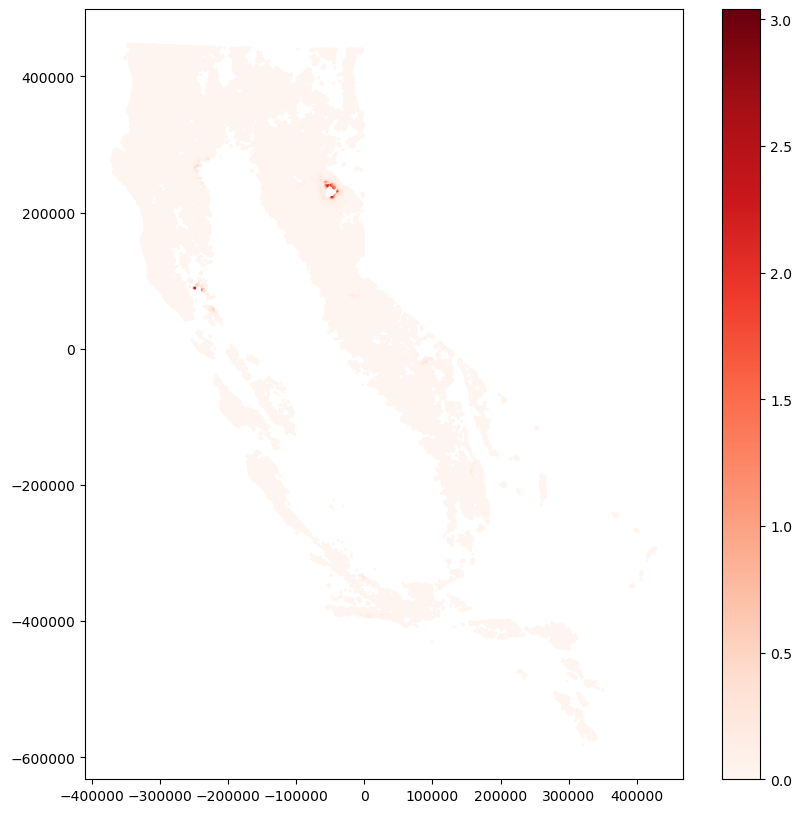

In [15]:
gdf[gdf["weights_1e-06_0.005"] != 0].plot(
    column="weights_1e-06_0.005",
    legend=True,
    figsize=(10, 10),
    cmap="Reds",
    markersize=1,
)